### Numerical Experiments

6 openml datasets with ids [31, 1464, 334, 333, 1504]
all four optimizers are compared

In [8]:
import openml

from openml import tasks

import HPO

import pysgpp

import sys

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn.metrics

from sklearn.model_selection import cross_val_score

import numpy as np
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor, KerasClassifier


def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)


def from_standard(lower, upper, value):
    return value*(upper-lower)+lower

BUDGET = 40
VERBOSE = 0
CV = 2
SCORING = 'neg_mean_squared_error'
TESTING = False

ITER = 2

BUDGETS = [i*10 for i in range(1, ITER+1)]

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_TIME = []
RANDOM_TIME = []
BAYESIAN_TIME = []
SPARSE_TIME = []

In [9]:
hyperparameterspace = {
    'loss': ["list", 'binary_crossentropy', 'categorical_crossentropy', 'binary_crossentropy', 'mean_absolute_error'],
    #'loss': ["list", 'mean_absolute_error', 'log_cosh'],
    'epochs': ["interval-int", 1, 200]
}


In [10]:
openml.datasets.list_datasets(output_format="dataframe")

ids = [31, 1464, 334, 333, 1504]

for i in range(len(ids)):
    DATASETS.append(str(ids[i]))
    
    # Get dataset by ID
    dataset = openml.datasets.get_dataset(ids[i])

    # Get the data itself as a dataframe (or otherwise)
    data, _, _, _ = dataset.get_data(dataset_format="array")

    X = torch.Tensor([x[:-1] for x in data])
    Y = torch.Tensor([[x[-1]] for x in data])
    
    dataset = HPO.Dataset(X, Y)

    ################## MODEL AND FUNCTION DEFINITION ####################

    # Function to create model, required for KerasClassifier
    def create_model(): 
        # create model
        model = Sequential()
        model.add(Dense(30, input_shape=(len(dataset.get_X()[0]),), activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(30, activation='relu'))
        model.add(Dense(len(dataset.get_Y()[0]), activation=None))
        # Compile model
        #model.compile(loss=loss,
        #              optimizer='adam', metrics=['mean_squared_error'])
        return model


    hyperparameterspace_special = {}
    for key in hyperparameterspace.keys():
        liste = []
        for i in range(1, len(hyperparameterspace[key])):
            liste.append(hyperparameterspace[key][i])
        hyperparameterspace_special[key] = liste


    def blackboxfunction(params):
        index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = hyperparameterspace_special["loss"][index]
        
        epochs = int(params[1])

        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(30, input_shape=(len(dataset.get_X()[0]),), activation='relu'))
            model.add(Dense(20, activation='relu'))
            model.add(Dense(30, activation='relu'))
            model.add(Dense(len(dataset.get_Y()[0]), activation=None))
            # Compile model
            model.compile(loss=loss, optimizer='adam', metrics=['mean_squared_error'])
            return model

        model = KerasClassifier(model=create_model, verbose=0)

        model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs)

        if TESTING:
            print("Test set is being used")
            Y_predicted = model.predict(dataset.get_X_test())
            if np.any(np.isnan(Y_predicted)):
                return 1000
            return sklearn.metrics.accuracy_score(dataset.get_Y_test(), Y_predicted)
        else:
            Y_predicted = model.predict(dataset.get_X_validation())
            if np.any(np.isnan(Y_predicted)):
                return 1000
            return -sklearn.metrics.accuracy_score(dataset.get_Y_validation(), Y_predicted)
    

    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(2)


        def eval(self, x):
            index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            loss = hyperparameterspace_special["loss"][index]
            epochs = int(from_standard(1, 400, x[1]))
            
            # Function to create model, required for KerasClassifier
            def create_model():
                # create model
                model = Sequential()
                model.add(Dense(30, input_shape=(len(dataset.get_X()[0]),), activation='relu'))
                model.add(Dense(20, activation='relu'))
                model.add(Dense(30, activation='relu'))
                model.add(Dense(len(dataset.get_Y()[0]), activation=None))
                # Compile model
                model.compile(loss=loss, optimizer='adam', metrics=['mean_squared_error'])
                return model

            model = KerasClassifier(model=create_model, verbose=0)

            # scores = cross_val_score(model, dataset.get_X(), dataset.get_Y(), cv=CV, scoring=SCORING)

            # return -scores.mean()

            model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs)

            if TESTING:
                Y_predicted = model.predict(dataset.get_X_test())
                if np.any(np.isnan(Y_predicted)):
                    return 1000
                return sklearn.metrics.accuracy_score(dataset.get_Y_test().tolist(), Y_predicted)
            else:
                Y_predicted = model.predict(dataset.get_X_validation())
                if np.any(np.isnan(Y_predicted)):
                    return 1000
                return sklearn.metrics.accuracy_score(dataset.get_Y_validation().tolist(), Y_predicted)
            

    ############################# GRID SEARCH #######################

    model = KerasClassifier(model=create_model, verbose=0)

    optimization = HPO.GridSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

    result = optimization.fit()

    Y_predicted = result.predict(dataset.get_X_test())

    GRID_RESULT.append(sklearn.metrics.accuracy_score(dataset.get_Y_test(), Y_predicted))

    ########################### RANDOM SEARCH #######################
    
    model = KerasClassifier(model=create_model, verbose=0)

    optimization = HPO.RandomSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

    result = optimization.fit()

    Y_predicted = result.predict(dataset.get_X_test())

    RANDOM_RESULT.append(sklearn.metrics.accuracy_score(dataset.get_Y_test(), Y_predicted))


    ########################### BAYESIAN OPT ##################### 
    optimization = HPO.BayesianOptimization(dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)


    result = optimization.fit()
    
    index_best = 0
    for i in range(len(result[1])):
        if result[1][i] == max(result[1]):
            index_best = i

    best_score = result[1][index_best]
    best_params = result[0][index_best]

    TESTING = True
    BAYESIAN_RESULT.append(blackboxfunction(best_params))
    TESTING = False


    ########################### SPARSE OPT ############################
    f = ExampleFunction()

    optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=2, adaptivity=0.9, optimizer="gradient_descent")

    result = optimization.fit()
    

    TESTING = True
    SPARSE_RESULT.append(f.eval(result[0]))
    SPARSE_RESULT_OPTIMIZED.append(f.eval(result[1]))
    TESTING = False
    



Dataset with id 31


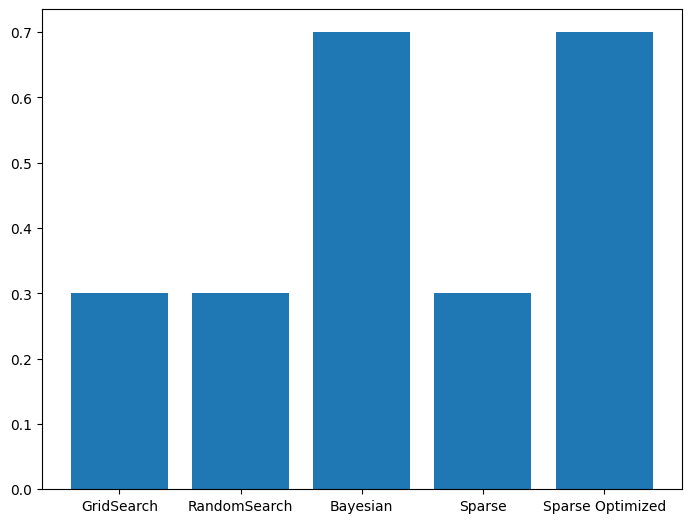

Dataset with id 1464


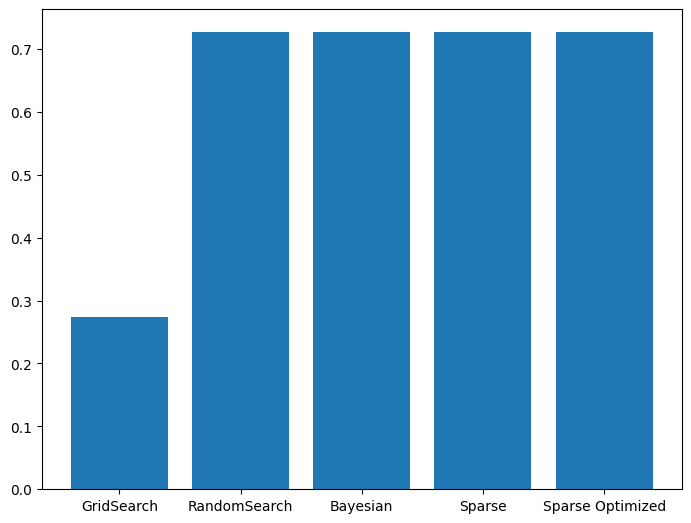

Dataset with id 334


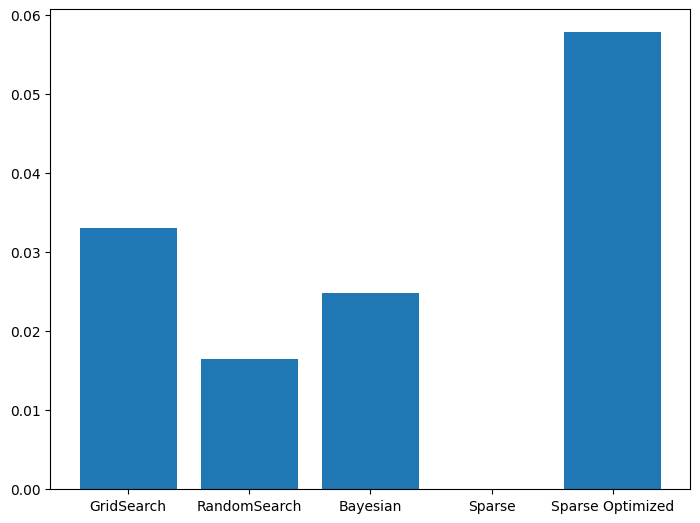

Dataset with id 333


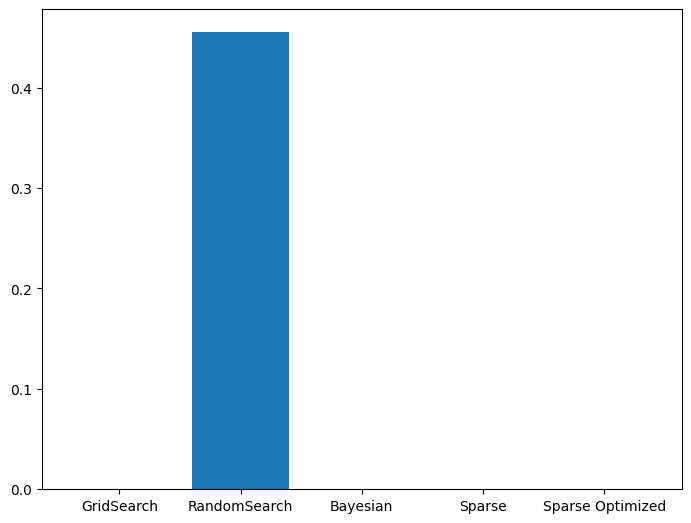

Dataset with id 1504


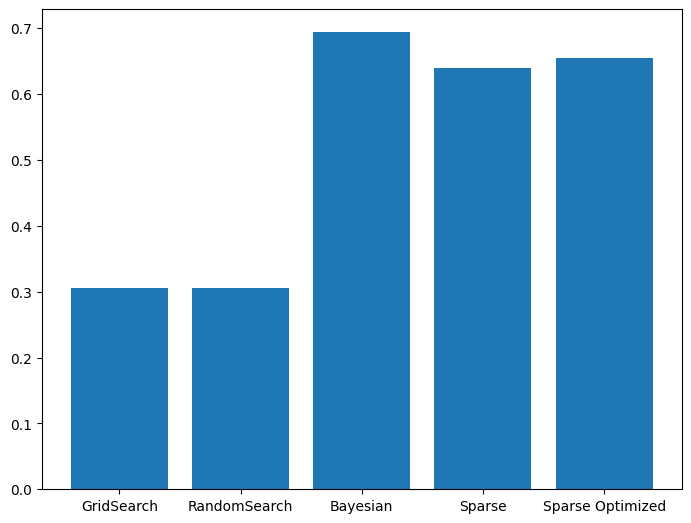

[0.3, 0.27333334, 0.03305785, 0.0, 0.30591258]
[0.3, 0.7266667, 0.016528925, 0.45535713, 0.30591258]
[0.7, 0.7266667, 0.024793388, 0.0, 0.6940874]
[0.3, 0.7266666666666667, 0.0, 0.0, 0.6401028277634961]
[0.7, 0.7266666666666667, 0.05785123966942149, 0.0, 0.6555269922879178]


In [ ]:
# plt.plot(DATASETS, GRID_RESULT, label = "Grid search")
# plt.plot(DATASETS, RANDOM_RESULT, label = "Random search")
# plt.plot(DATASETS, BAYESIAN_RESULT, label = "Bayesian Optimization")
# plt.plot(DATASETS, SPARSE_RESULT, label = "Sparse grid search")
# plt.plot(DATASETS, SPARSE_RESULT_OPTIMIZED, label = "Sparse grid search (optimized)")


# plt.xlabel('Dataset ID')
# plt.ylabel('Mean squared error')

# plt.title('Result depending on budget')
  
# # show a legend on the plot
# plt.legend()
  
# # function to show the plot     
# plt.show()

for i in range(len(ids)):
    print("Dataset with id", ids[i])

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    opts = ['GridSearch', 'RandomSearch', 'Bayesian', 'Sparse', 'Sparse Optimized']
    results = []
    results.append(GRID_RESULT[i])
    results.append(RANDOM_RESULT[i])
    results.append(BAYESIAN_RESULT[i])
    results.append(SPARSE_RESULT[i])
    results.append(SPARSE_RESULT_OPTIMIZED[i])
    ax.bar(opts, results)
    plt.show()


print(GRID_RESULT)
print(RANDOM_RESULT)
print(BAYESIAN_RESULT)
print(SPARSE_RESULT)
print(SPARSE_RESULT_OPTIMIZED)